# Benchmark for Clustering

 In this Benchmark we are using the LS Heuristic to label d-dimensional Datasets.
 We start by importing dependencies.

In [1]:
"""Load/import helper functions"""

from LocalPopular import  time_tester, calculate_scores_clustering

from LocalStable import locally_stable_clustering_with_euclid_graphs

from GraphFunctions import my_make_circles, randomize_graph_pos_labels

import importlib
import PlotHelperFunctions
importlib.reload(PlotHelperFunctions)

from sklearn.cluster import KMeans, DBSCAN
from sklearn.datasets import make_moons, load_breast_cancer, load_iris
from sklearn.metrics import rand_score

## Create Graphs

For our clustering simulations, we are using four datasets.

- **Moon dataset**: Two half-moons generated by make_moons (300 points, 0:05 noise)
- **3-Circles dataset**: 300 points in three slightly overlapping circles centered at (0.5, 0.5),(0.7, 0.3), and (0:1, 0.7) with radius 0.2 and Gaussian noise (std = 0.05).
- **Breast cancer Wisconsin dataset**: 569 samples from diagnostic images (30 dimensional datapoints).
- **Iris dataset**: 150 samples from three Iris species, features are sepal and petal sizes.



In [2]:
# Moon Dataset
moon_agents,moon_truth = make_moons(n_samples=300, noise=0.05)

# Circle Dataset
circle_agents, circle_truth = my_make_circles(300)

# Cancer Dataset
cancer = load_breast_cancer()
cancer_agents = cancer['data']
cancer_truth = cancer['target']

# Iris Dataset
iris = load_iris()
iris_agents = iris['data']
iris_truth = iris['target']

## Run the algorithms

We will now run the LS Heuristic in several modes.
We will test the three introduced domains of FEN games:

- Friend-appreciating
- Enemy averse
- Balanced

Additionally for each mode we will run three different friendship-/enemy-thresholds:

- (0.2, 0.2)
- (0.25, 0.35)
- (0.4, 0.4)

These thresholds (a fraction that will be compared to the diameter of the Graph) will be used to create the friendship- and enemy-relation between data points.


Finally we will use different initial clusterings: 

- putting each agent into a singleton cluster (LocStab-S), 
- dividing agents randomly into k clusters where k is the predicted number of clusters (LocStab-P), and 
- using the output of the k-means/DBSCAN algorithm (LocStab-KM/D).


We also run k-means and DBSCAN for comparison

If you want to run this code yourself we suggest reducing the repetitions from 10 to 1.


In [3]:
import itertools
import timeit

import pandas as pd
import numbers

dfs = []
labels = [(0.2,0.2), (0.25,0.35),(0.4,0.4)]

for treshold in labels:
    collected_data = {}
    for repetitions in range(10):
        f = treshold[0]   #f-bound
        e = treshold[1]   

        data = [ moon_agents,circle_agents,cancer_agents,iris_agents]
        expected_clusters = [2,3,2,3]
        graph_names = ['Moons','3 Circles', 'Cancer', 'Iris']
        graph_truths =  [moon_truth,circle_truth,cancer_truth,iris_truth]
        
        
        kmeans = lambda agents, clusters: KMeans(n_clusters = clusters).fit_predict(agents)
        dbscan = lambda agents, clusters: DBSCAN(eps=0.2, min_samples=5).fit_predict(agents)
        
        kmeans_out = None
        dbscan_out = None
        
        lp_a_b =lambda agents, initial_clustering, pre, allow_exit: locally_stable_clustering_with_euclid_graphs(agents, f, e, initial_clustering,allow_exit,mode='B',pre=pre)
        lp_a_f =lambda agents, initial_clustering, pre, allow_exit: locally_stable_clustering_with_euclid_graphs(agents, f, e, initial_clustering, allow_exit, mode='F',pre=pre)
        lp_a_e =lambda agents, initial_clustering, pre, allow_exit: locally_stable_clustering_with_euclid_graphs(agents, f, e, initial_clustering, allow_exit, mode='E',pre=pre)
        
        algorithms = [ kmeans, dbscan,lp_a_b,lp_a_f,lp_a_e]
        algo_names = [ 'kmeans', 'dbscan','LS (Balanced) Heuristic',\
                       'LS (Friend-Oriented) Heuristic','LS (Enemy-Averse) Heuristic']
        is_lp_heuristic = [False,False,True, True, True]
        
       

        for ((graph, g_name,clusters,truth), (algo, a_name,lp_heuristic)) in \
            itertools.product(zip(data, graph_names, expected_clusters,graph_truths), zip(algorithms, algo_names,is_lp_heuristic)):

            graph,truth = randomize_graph_pos_labels(graph,truth)

            graph = [graph]
            truth = [truth]
                
            agents = graph
        
            if lp_heuristic:
                # start with everyone alone
                a_name_modified = a_name + ' starting with everyone alone'
                allow_exit = False
                test_callable = lambda a: list(algo(a,len(agents[0]),None,allow_exit).values())
                times,outputs = time_tester(test_callable,graph)
                avg_time = sum(times)/len(times)
                scores = calculate_scores_clustering(outputs,truth,agents)
                scores['Time'] = avg_time
        
                if (a_name_modified, g_name) not in collected_data:
                    collected_data[(a_name_modified, g_name)] = []
                collected_data[(a_name_modified, g_name)].append(scores)
        
                # start with random clustering 
        
                a_name_modified = a_name + ' starting with predicted number of clusters'
                allow_exit = False
                test_callable = lambda a: list(algo(a,clusters,None,allow_exit).values())
                times,outputs = time_tester(test_callable,graph)
                avg_time = sum(times)/len(times)
                scores = calculate_scores_clustering(outputs,truth,agents)
                scores['Time'] = avg_time
        
                if (a_name_modified, g_name) not in collected_data:
                    collected_data[(a_name_modified, g_name)] = []
                collected_data[(a_name_modified, g_name)].append(scores)
        
        
                # start with the output of k-means
                a_name_modified = a_name + ' starting with the output of k-means'
                allow_exit = False
                test_callable = lambda a: list(algo(a,clusters,kmeans,allow_exit).values())
                times,outputs = time_tester(test_callable,graph)
                avg_time = sum(times)/len(times)
                scores = calculate_scores_clustering(outputs,truth,agents)
        
                rand_score_with_init = sum(rand_score(out, k) for out, k in zip(outputs, kmeans_out)) / len(outputs)
                scores['Rand Score with initial clustering'] = rand_score_with_init
                
                scores['Time'] = avg_time

                if (a_name_modified, g_name) not in collected_data:
                    collected_data[(a_name_modified, g_name)] = []
                collected_data[(a_name_modified, g_name)].append(scores)
        
                # start with the output of dbscan
                a_name_modified = a_name + ' starting with the output of dbscan'
                allow_exit = False
                test_callable = lambda a: list(algo(a,clusters,dbscan,allow_exit).values())
                times,outputs = time_tester(test_callable,graph)
                avg_time = sum(times)/len(times)
                scores = calculate_scores_clustering(outputs,truth,agents)
        
                rand_score_with_init = sum(rand_score(out, db) for out, db in zip(outputs, dbscan_out)) / len(outputs)
                scores['Rand Score with initial clustering'] = rand_score_with_init
                   
                scores['Time'] = avg_time
        
                if (a_name_modified, g_name) not in collected_data:
                    collected_data[(a_name_modified, g_name)] = []
                collected_data[(a_name_modified, g_name)].append(scores)

            
            else:
        
                test_callable = lambda a : algo(a, clusters)
                    
                times,outputs = time_tester(test_callable,graph)
                if(algo == kmeans):
                    kmeans_out = outputs
                if(algo == dbscan):
                    dbscan_out = outputs
                avg_time = sum(times)/len(times)
                scores = calculate_scores_clustering(outputs,truth,agents)
                scores['Time'] = avg_time
                
                if (a_name, g_name) not in collected_data:
                    collected_data[(a_name, g_name)] = []
                collected_data[(a_name, g_name)].append(scores)

    records = []

    for (method, dataset), metrics_list in collected_data.items():
        record = {'Method': method, 'Dataset': dataset}
        keys = metrics_list[0].keys()
        for key in keys:
            values = [m[key] for m in metrics_list if isinstance(m[key], numbers.Number)]
            if values:
                mean = sum(values) / len(values)
                std = (sum((v - mean) ** 2 for v in values) / len(values)) ** 0.5
                record[key] = (mean, std)
            else:
                record[key] = metrics_list[0][key]  # fallback for non-numeric
        records.append(record)
    
    df = pd.DataFrame(records)
    
    dfs.append(df)


Quick check for the maximum standard deviation of the scores.

In [4]:
# Get maximum standart deviations
max_stds = {}

for df in dfs:
    for col in ['Rand Index', 'Silhouette Score']:
        stds = df[col].apply(lambda x: x[1] if isinstance(x, (tuple, list)) else float('nan'))
        max_stds[col] = max(max_stds.get(col, float('-inf')), stds.max())

print(max_stds)

{'Rand Index': np.float64(0.16721504403539453), 'Silhouette Score': np.float64(0.2864041346524497)}


## Printing Figures


Figure saved as ./figures/StableClustering/Cancer-Rand Index.png


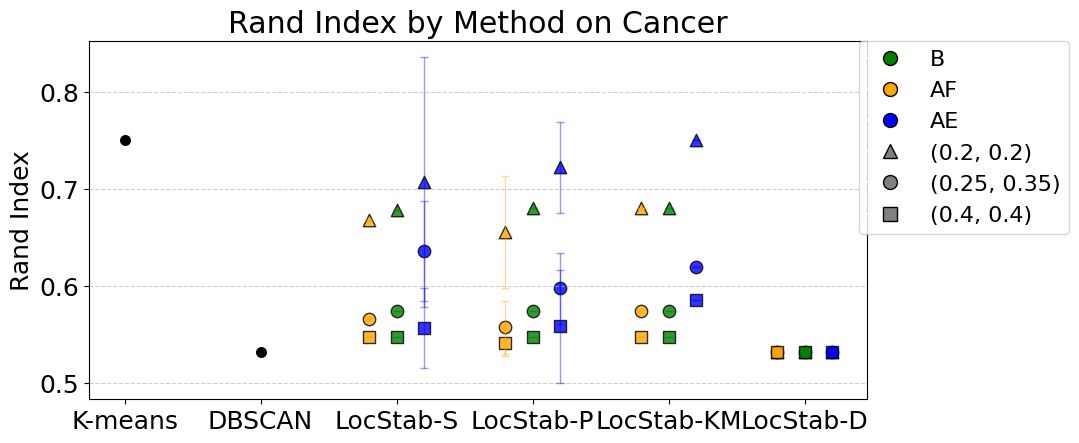

Figure saved as ./figures/StableClustering/Cancer-Silhouette Score.png


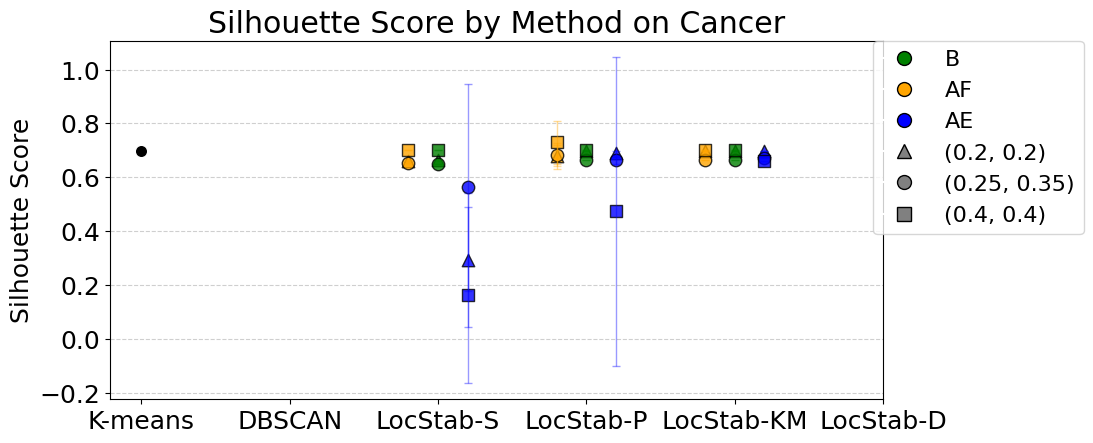

Figure saved as ./figures/StableClustering/Iris-Rand Index.png


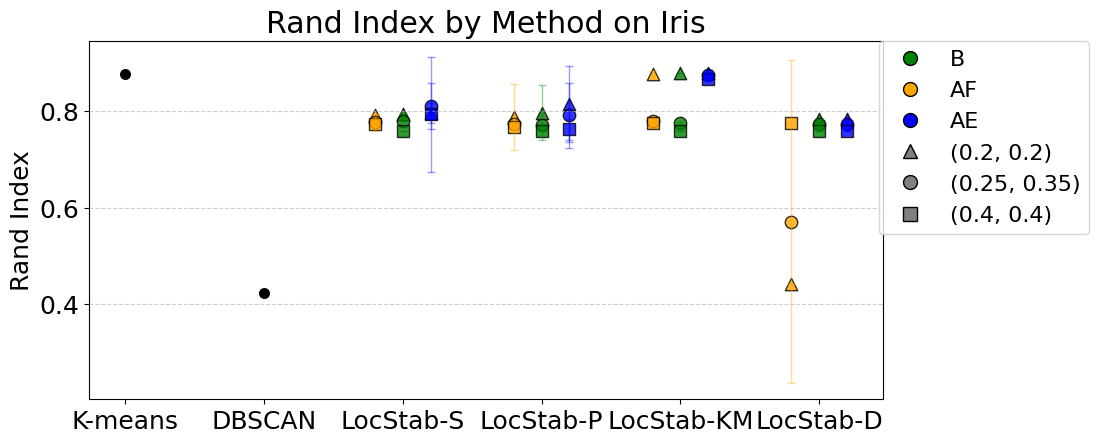

Figure saved as ./figures/StableClustering/Iris-Silhouette Score.png


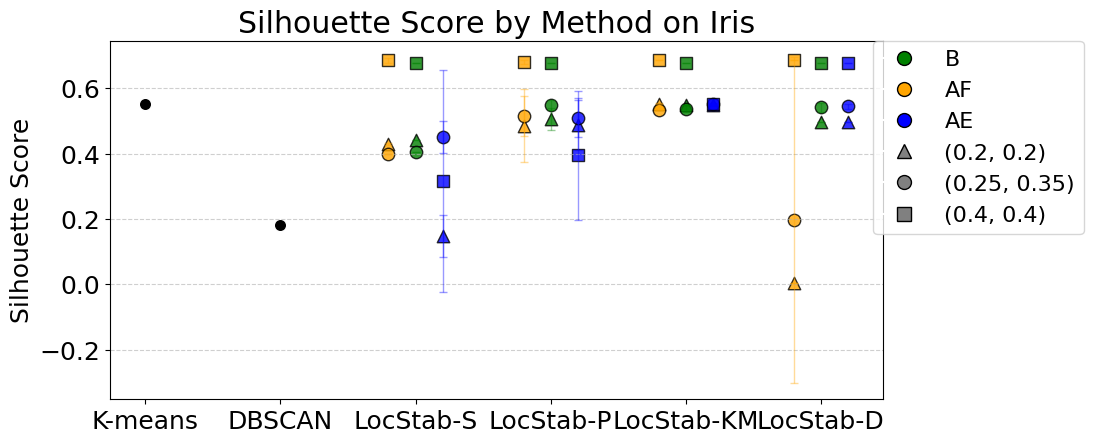

Figure saved as ./figures/StableClustering/Moons-Rand Index.png


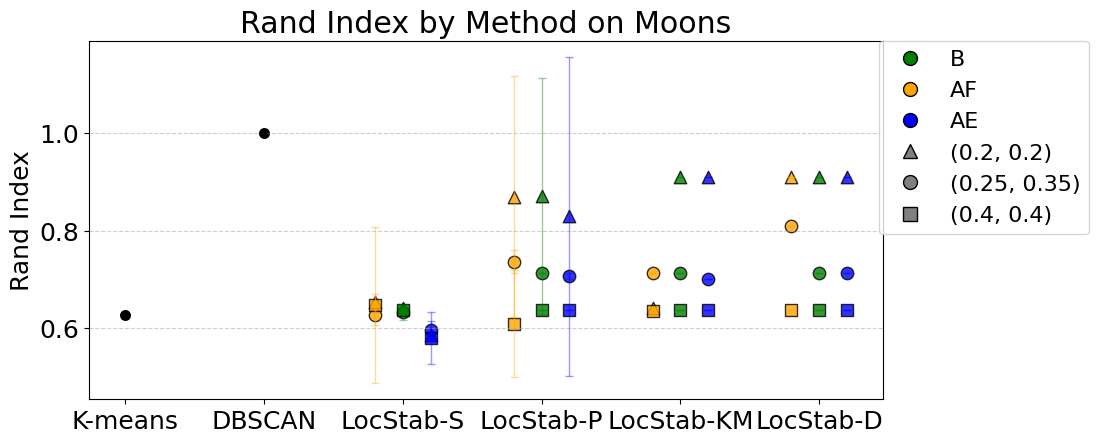

Figure saved as ./figures/StableClustering/Moons-Silhouette Score.png


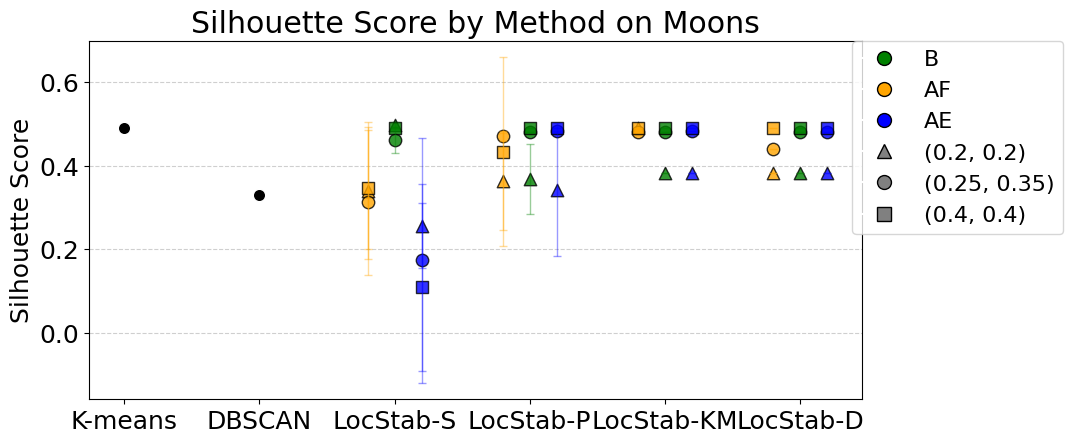

Figure saved as ./figures/StableClustering/3 Circles-Rand Index.png


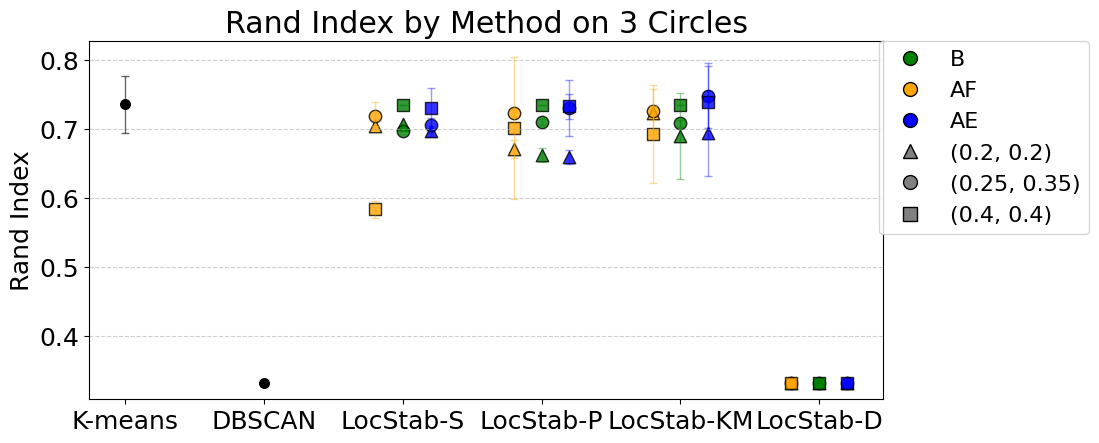

Figure saved as ./figures/StableClustering/3 Circles-Silhouette Score.png


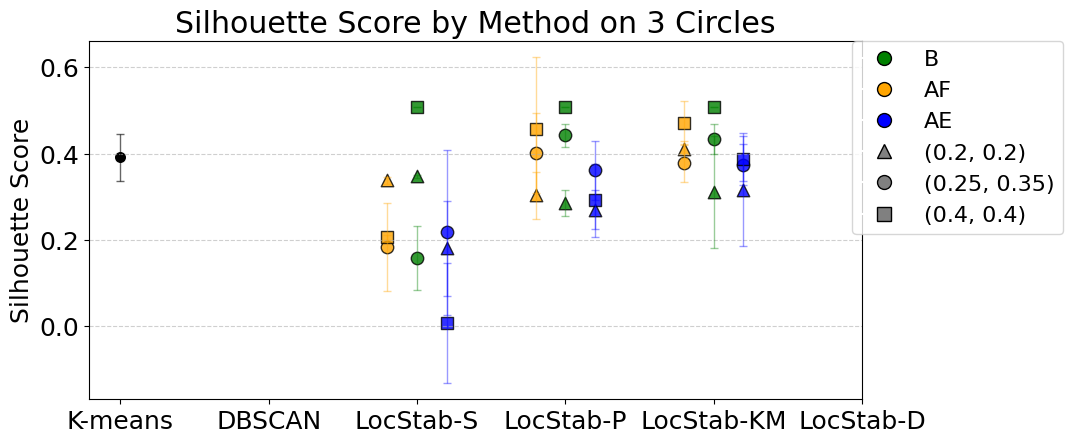

In [5]:

score_cols = ['Rand Index', 'Silhouette Score']


labels = [(0.2,0.2),(0.25,0.35),(0.4,.4)]
# Plot the results
for Dataset in ['Cancer', 'Iris', 'Moons', '3 Circles']:
    for score in score_cols:
        PlotHelperFunctions.plot_and_save_clustering(
            dfs, labels, Dataset, score, mode = "LS",
            save_path=f'./figures/StableClustering/{Dataset}-{score}.png'
        )

In [6]:
import ast
import numpy as np
import pandas as pd

# Compute the mean Rand Scores with the initial clustering

all_values = []

for df in dfs:
    col = 'Rand Score with initial clustering'
    if col in df.columns:
        values = df[col].apply(
            lambda x: ast.literal_eval(x)[0] if isinstance(x, str) and x.startswith('(')
            else x[0] if isinstance(x, (tuple, list))
            else float('nan')
        )
        all_values.extend(values.dropna().tolist())

# Convert to numpy array for convenience
all_values = np.array(all_values)

# Compute min, max, and average, ignoring NaNs
min_val = np.nanmin(all_values)
max_val = np.nanmax(all_values)
avg_val = np.nanmean(all_values)

print(f"Min: {min_val}")
print(f"Max: {max_val}")
print(f"Average: {avg_val}")


Min: 0.4357046979865771
Max: 1.0
Average: 0.6450033748702801


## Saving the dataframe as csv

In [7]:
for i,df in enumerate(dfs):
    df.to_csv(f'./csv/StableClustering/dataset-{i}.csv')